### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
# I only leave the plot here, the whole code is below

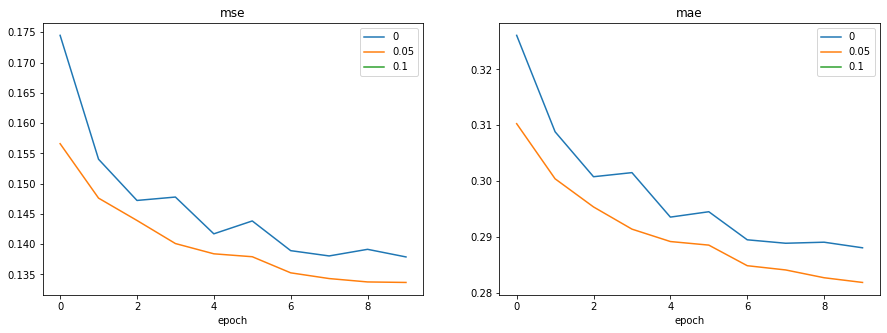

In [30]:
dr = pd.read_csv('dropout.csv', index_col=0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("mse")
plt.xlabel("epoch")
for dropout in dropouts:
    plt.plot(dr[dr.dropout == dropout].epoch, dr[dr.dropout == dropout].mse)
plt.legend(dropouts)

plt.subplot(1, 2, 2)
plt.title("mae")
plt.xlabel("epoch")
for dropout in dropouts:
    plt.plot(dr[dr.dropout == dropout].epoch, dr[dr.dropout == dropout].mae)
plt.legend(dropouts)
plt.show()

### A short report

Please tell us what you did and how did it work.

I trained model from seminar with different dropouts, and then built plots for mse and mae for each epoch, i guess...

As it's seen in the plot, the dropout of 0.05 makes mse and mae on validation less than no dropout. 

The training proccess took longer than i thought, so that's the only thing i did :(


## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

# plt.figure(figsize=[8, 4])
# plt.subplot(1, 2, 1)
# plt.hist(data["SalaryNormalized"], bins=20);

# plt.subplot(1, 2, 2)
# plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

# data.sample(1)

In [6]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data['FullDescription'] = data['FullDescription'].apply(
    lambda x: ' '.join(tokenizer.tokenize(x.lower()))
    )
data['Title'] = data['Title'].apply(
    lambda x: ' '.join(tokenizer.tokenize(str(x).lower()))
    )

In [7]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for row in data['FullDescription'].values:
    token_counts.update(row.split())

for row in data['Title'].values:
    token_counts.update(row.split())

In [8]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [9]:
token_to_id = {token: i for i, token in enumerate(tokens)}

In [10]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False).fit(data[categorical_columns].apply(dict, axis=1))

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


# Batches and metrics

In [14]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

def print_metrics(model, data, batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


# Model

In [15]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=16, dropout=0):
        super().__init__()

        self.title_emb = torch.nn.Embedding(len(tokens), hid_size)
        self.title_drp = torch.nn.Dropout(dropout)
        self.title_mp = torch.nn.MaxPool1d(kernel_size=2)
        
        self.description_emb = torch.nn.Embedding(len(tokens), hid_size)
        self.description_drp = torch.nn.Dropout(dropout)
        self.description_mp = torch.nn.MaxPool1d(kernel_size=2)
        
        self.categorical_lin1 = torch.nn.Linear(n_cat_features, hid_size)
        self.categorical_drp = torch.nn.Dropout(dropout)
        self.categorical_relu = torch.nn.ReLU()
        self.categorical_lin2 = torch.nn.Linear(hid_size, hid_size)
        
        self.linear = torch.nn.Linear(hid_size // 2 + hid_size // 2 + hid_size, 1)
        
        
    def forward(self, batch):
        title = batch['Title']
        title = self.title_emb(title).mean(dim=1)
        title = self.title_drp(title)
        title = self.title_mp(title)
        
        description = batch['FullDescription']
        description = self.description_emb(description).mean(dim=1)
        description = self.description_drp(description)
        description = self.description_mp(description)
        
        categorical = batch['Categorical']
        categorical = self.categorical_lin1(categorical)
        categorical = self.categorical_drp(categorical)
        categorical = self.categorical_relu(categorical)
        categorical = self.categorical_lin2(categorical)
        
        all = torch.cat((title, description, categorical), dim=1)
        all = self.linear(all)

        return all.squeeze()

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 128
EPOCHS = 5

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, batch_size=BATCH_SIZE, device=device)

# Dropout

In [22]:
dropout_results = pd.DataFrame()
dropouts = [0, 0.05, 0.1]

In [23]:
BATCH_SIZE = 64
EPOCHS = 10

for dropout in dropouts:
    print(f"dropout: {dropout:.2f}")
    model = SalaryPredictor(hid_size=16, dropout=dropout).to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                total=len(data_train) // BATCH_SIZE
            ):
            pred = model(batch)
            loss = criterion(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        mse, mae = print_metrics(model, data_val, batch_size=BATCH_SIZE, device=device)
        dropout_results = dropout_results.append({
            'dropout': dropout,
            'epoch': epoch,
            'mse': mse,
            'mae': mae,
            'hid_size': 16,
        }, ignore_index=True)

        dropout_results.to_csv('dropout2.csv')

dropout: 0.00
epoch: 0


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.17449
Mean absolute error: 0.32608
epoch: 1


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.15403
Mean absolute error: 0.30882
epoch: 2


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14722
Mean absolute error: 0.30077
epoch: 3


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14778
Mean absolute error: 0.30150
epoch: 4


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14170
Mean absolute error: 0.29354
epoch: 5


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14383
Mean absolute error: 0.29450
epoch: 6


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13892
Mean absolute error: 0.28948
epoch: 7


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13805
Mean absolute error: 0.28886
epoch: 8


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13914
Mean absolute error: 0.28905
epoch: 9


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13789
Mean absolute error: 0.28805
dropout: 0.05
epoch: 0


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.15660
Mean absolute error: 0.31027
epoch: 1


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14760
Mean absolute error: 0.30040
epoch: 2


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14391
Mean absolute error: 0.29536
epoch: 3


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.14010
Mean absolute error: 0.29139
epoch: 4


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13840
Mean absolute error: 0.28917
epoch: 5


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13792
Mean absolute error: 0.28853
epoch: 6


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13526
Mean absolute error: 0.28484
epoch: 7


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13431
Mean absolute error: 0.28408
epoch: 8


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13375
Mean absolute error: 0.28268
epoch: 9


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13367
Mean absolute error: 0.28184
dropout: 0.10
epoch: 0


  0%|          | 0/3059 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [28]:
dropout_results

,dropout,epoch,mse,mae,hid_size
0,0.00,0.0,0.174492,0.326081,16
1,0.00,1.0,0.154026,0.308819,16
2,0.00,2.0,0.147218,0.300770,16
3,0.00,3.0,0.147779,0.301503,16
4,0.00,4.0,0.141703,0.293539,16
5,0.00,5.0,0.143831,0.294501,16
6,0.00,6.0,0.138924,0.289477,16
7,0.00,7.0,0.138051,0.288860,16
8,0.00,8.0,0.139144,0.289047,16
9,0.00,9.0,0.137885,0.288046,16


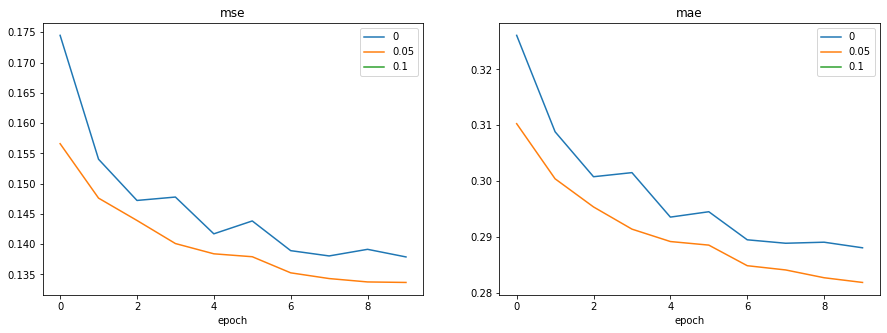

In [25]:
dr = pd.read_csv('dropout.csv', index_col=0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("mse")
plt.xlabel("epoch")
for dropout in dropouts:
    plt.plot(dr[dr.dropout == dropout].epoch, dr[dr.dropout == dropout].mse)
plt.legend(dropouts)

plt.subplot(1, 2, 2)
plt.title("mae")
plt.xlabel("epoch")
for dropout in dropouts:
    plt.plot(dr[dr.dropout == dropout].epoch, dr[dr.dropout == dropout].mae)
plt.legend(dropouts)
